In [2]:
library(tidyverse)
library(patchwork)

In [4]:
# adjust plot size rendered inline
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)

# Select Serine Protease vs Tick Inhibitor AF-Multimer Predictions
This notebook analyzes results for comparing select human serine proteases against all 10 tick putative serine protease inhibitors that were selected for protein purification. These serine proteases were selected based on an initial screen of just `Amblyomma-americanum_evm.model.contig-94090-1.4` against nearly 500 human serine proteases and selecting those with a confidence score above 0.75. This left us with 34 serine proteases that are mostly homologous trypsin proteases such as chymotrpsins, kallikrein-like peptidases, and granzymes. This notebook takes the previous results for the preliminary run and combines with the updated results with the remaining 9 tick protease inhibitors against the filtered set of serine proteases. 
Summaries of primary expression for each protein in human tissues were retrieved for each gene in NCBI, which summarizes data from [Fagerberg et al. 2014](https://pubmed.ncbi.nlm.nih.gov/24309898/) which analyzed gene expression in 27 different tissues from 95 healthy humans.

In [5]:
# read in data and merge tables

# serine protease uniprot metadata with expression data 
# for each serine protease the main cell type or tissue that it is expressed in is recorded for plotting, specifically highlighting those expressed in immune cells and skin, all other types are listed as "other"
serine_protease_metadata <- read.csv("../metadata/select-serine-protease-expression-metadata.csv")

# preliminary alphafold-multimer results from 94090-1.4
# filtered to the top hits for 35 serine proteases that were then screened against the other 9 protease inhibitors
preliminary_filtered_results <- read.csv("../results/serine_protease_results/Amblyomma-americanum-94090-1.4-serine-protease-afmultimer-top-hits.csv") %>% 
    select(-dscript_confidence_score, -reviewed, -uniprot_name, -annotation, -length)

# second run alphafold-multimer results for remaining tick protease inhibitors
run2_select_results <- read.csv("../results/serine_protease_results/Amblyomma-americanum-full-tick-select-serine-protease-afmultimer-comps.csv", col.names = c("amblyomma_protein", "uniprot_id", "pTM", "ipTM", "afmultimer_ranking_confidence"))

# full results
combined_results <- rbind(preliminary_filtered_results, run2_select_results)

# results with metadata
combined_results_metadata <- left_join(combined_results, serine_protease_metadata)

Joining with `by = join_by(uniprot_id)`


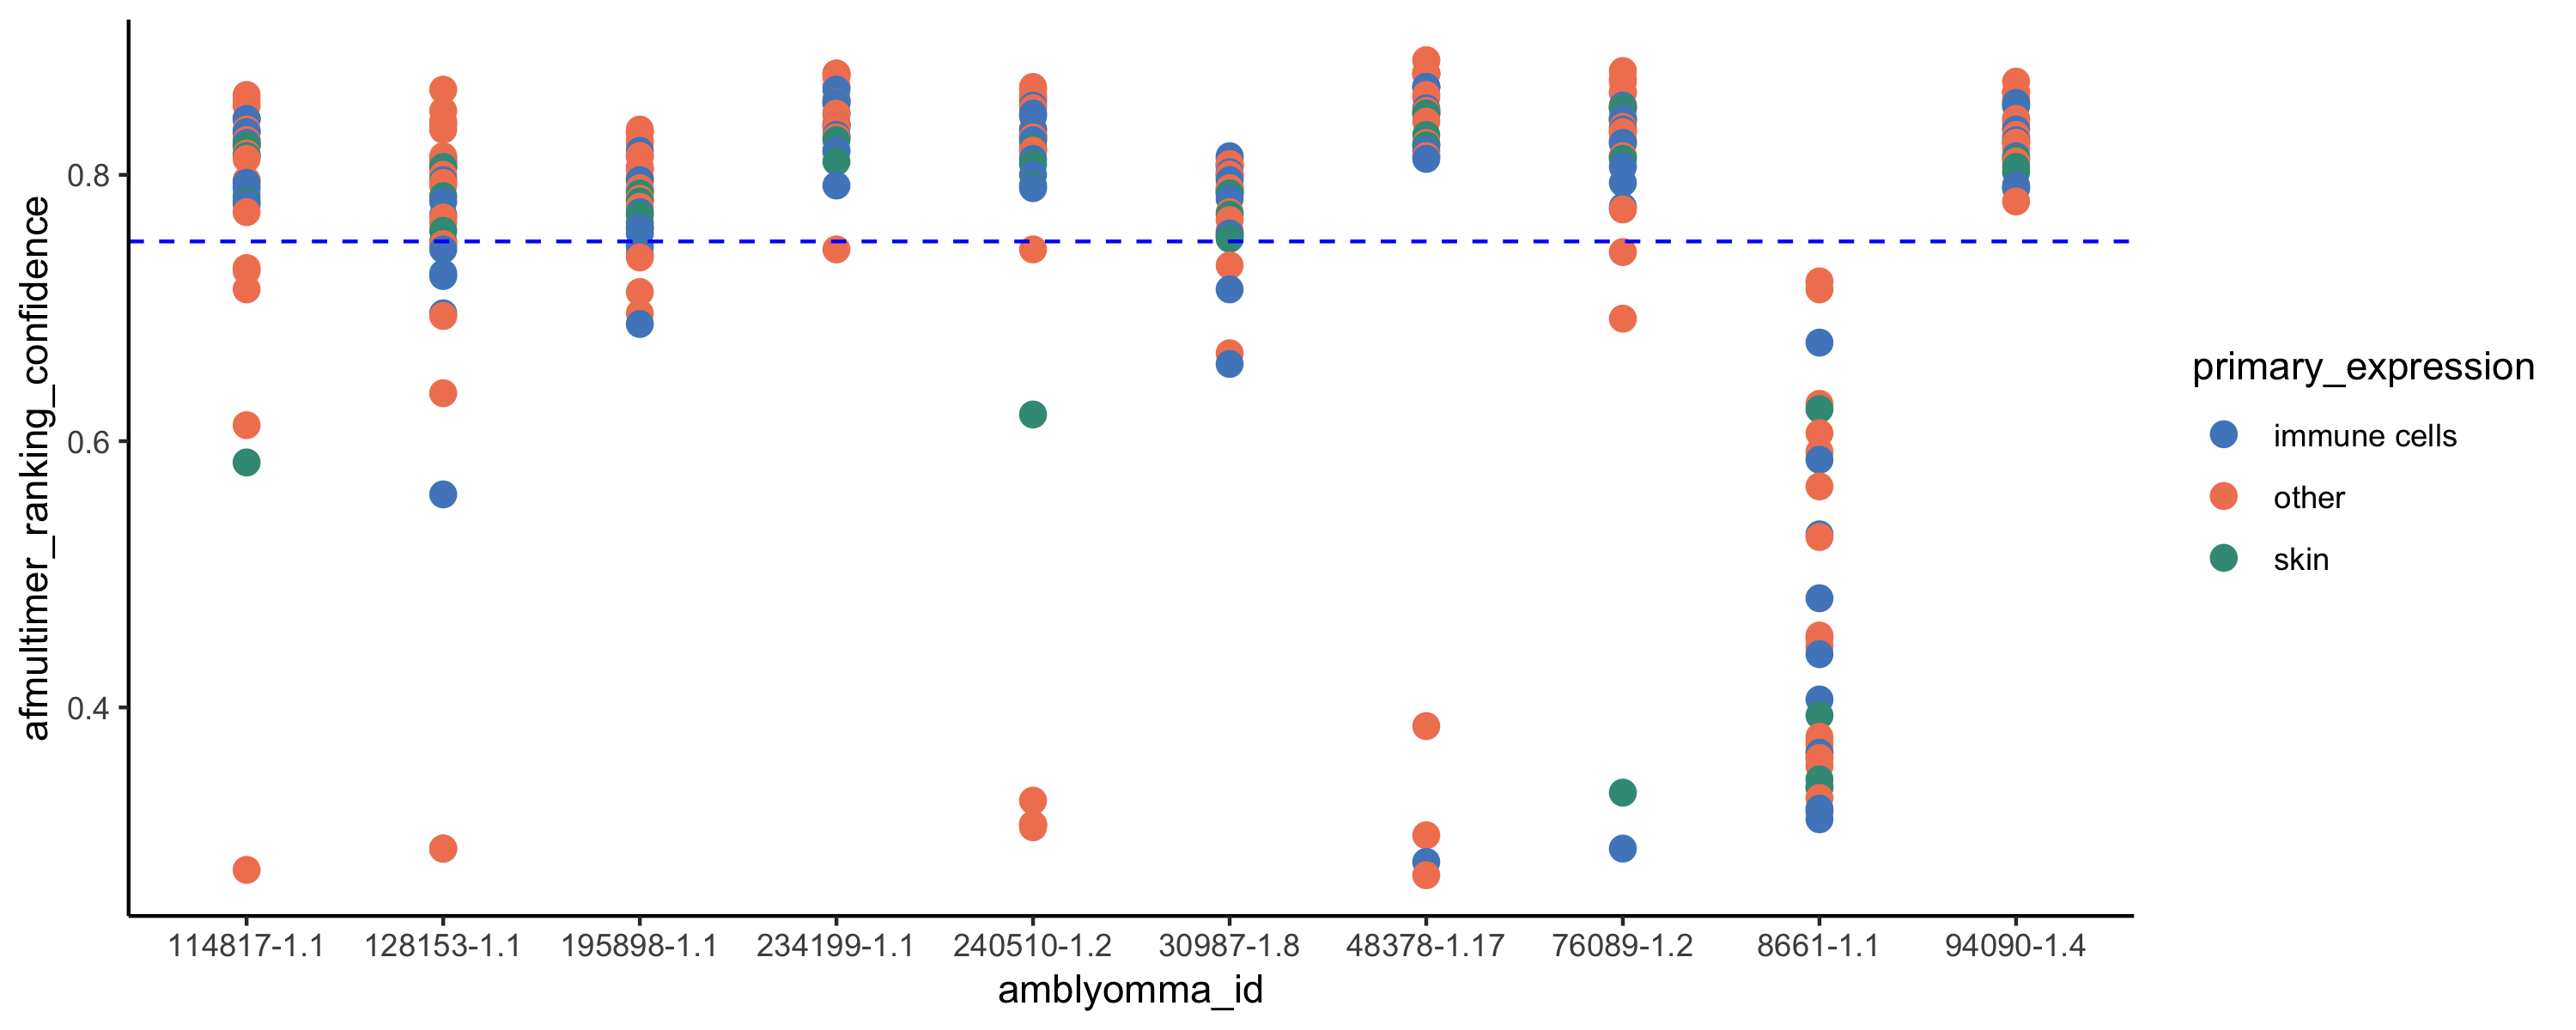

In [ ]:
# plot all results colored by the main expression cell type/tissue
all_results_colored_plot <- combined_results_metadata %>% 
    mutate(amblyomma_id = gsub("Amblyomma-americanum_evm.model.contig-", "", amblyomma_protein)) %>% 
    filter(primary_expression != "none") %>% 
    ggplot(aes(x=amblyomma_id, y=afmultimer_ranking_confidence)) +
    geom_point(aes(color = primary_expression), size=3) +
    geom_hline(yintercept = 0.75, linetype = "dashed", color = "blue") +
    scale_color_manual(values = c("#5088C5", "#F28360", "#3B9886")) +
    theme_classic()

all_results_colored_plot

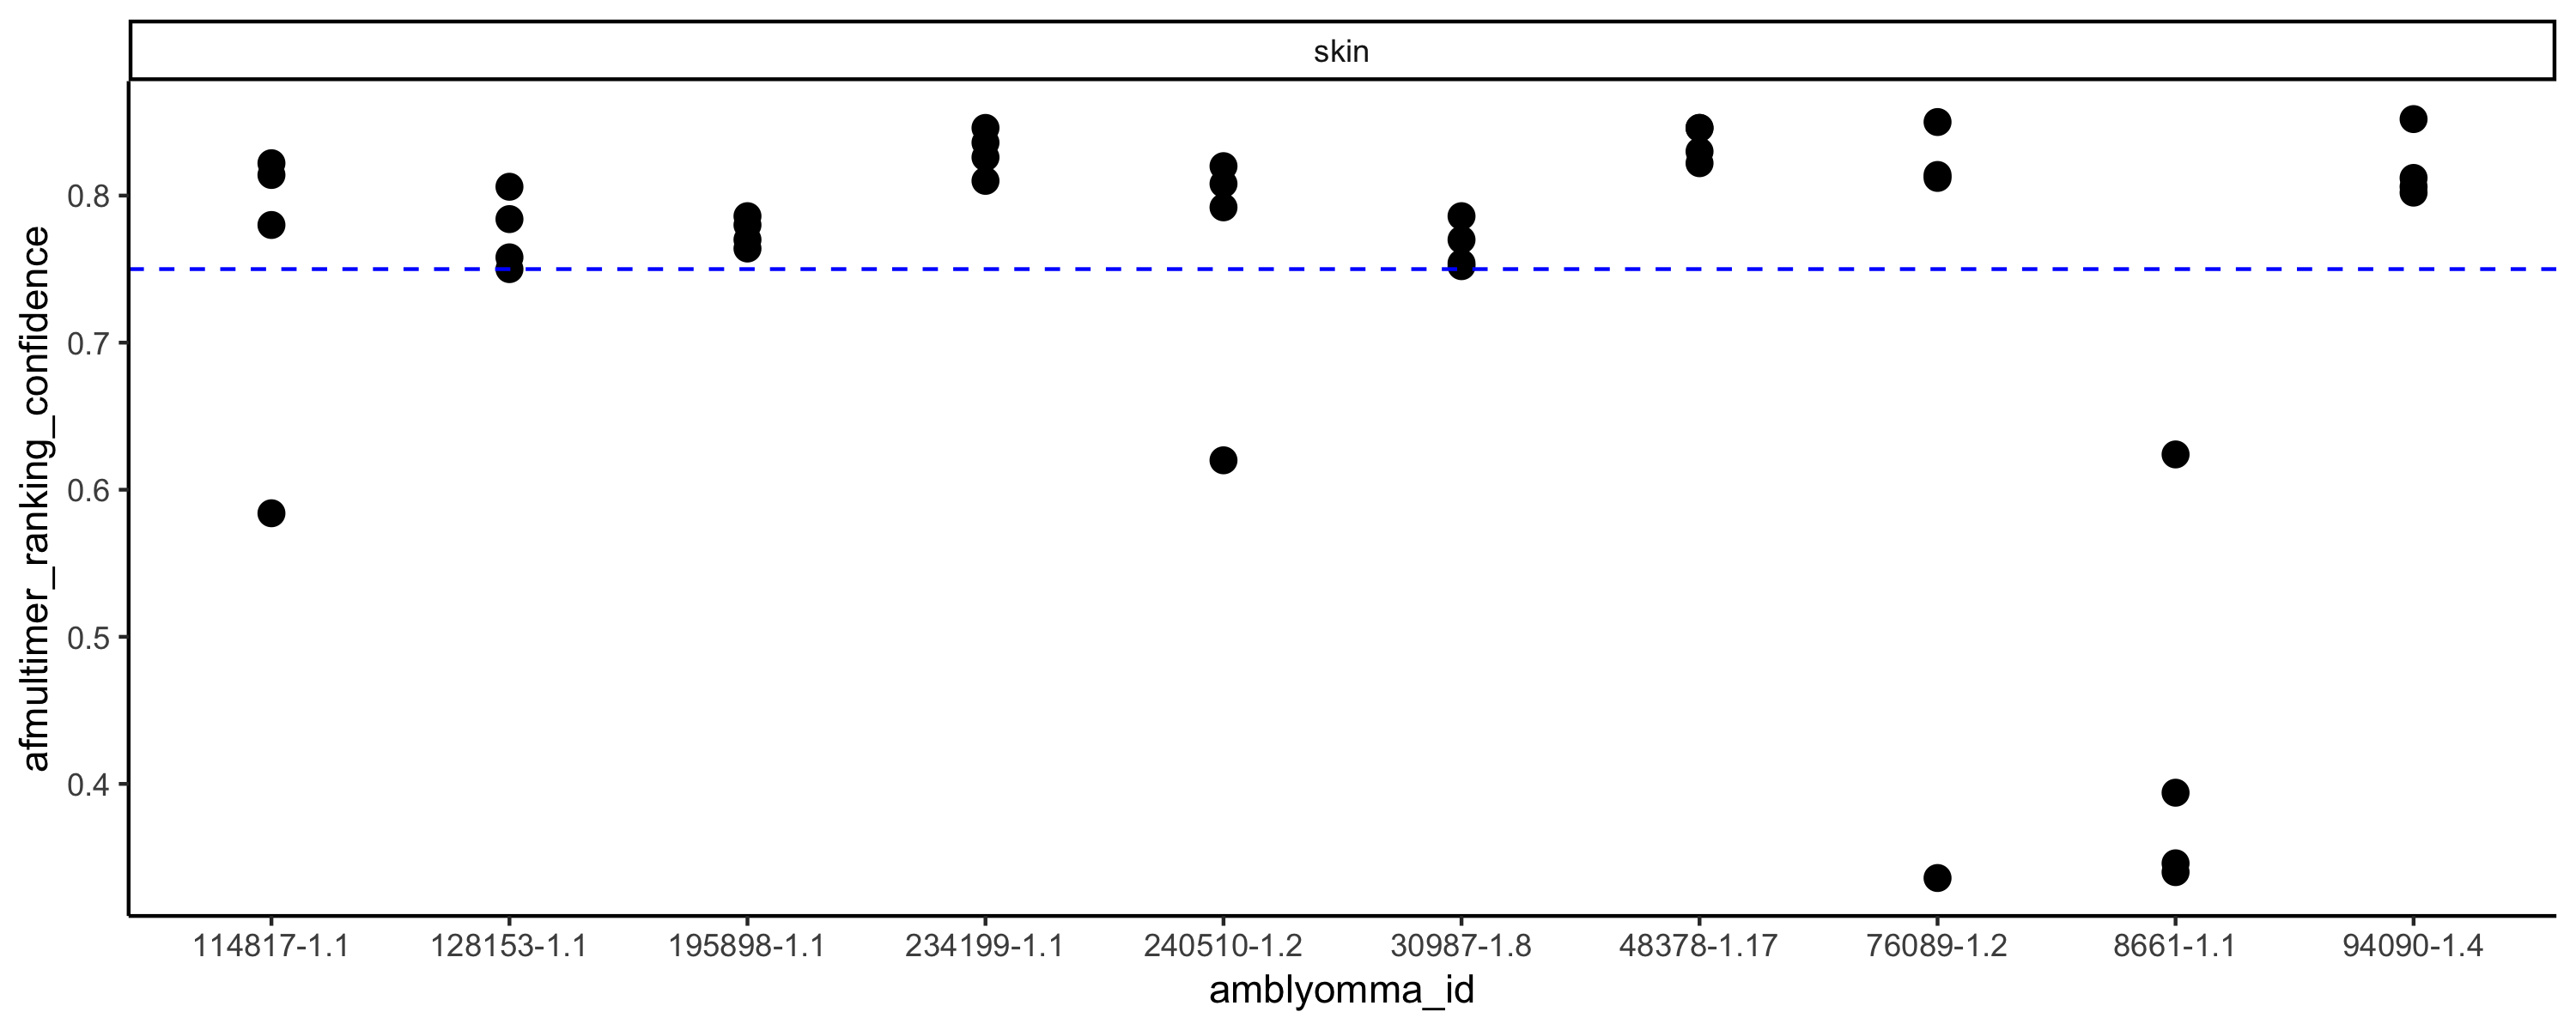

In [7]:
# filter for proteins where primary expression is skin

skin_results_plot <- combined_results_metadata %>% 
    mutate(amblyomma_id = gsub("Amblyomma-americanum_evm.model.contig-", "", amblyomma_protein)) %>% 
    filter(primary_expression == "skin") %>% 
    ggplot(aes(x=amblyomma_id, y=afmultimer_ranking_confidence)) +
    geom_point(size=3) +
    facet_wrap(~ primary_expression, ncol = 1) +
    geom_hline(yintercept = 0.75, linetype = "dashed", color = "blue") +
    theme_classic()

skin_results_plot

In [8]:
# save results tables and plots 

# final table of results
write.table(combined_results_metadata, "../results/serine_protease_results/2024-04-11-final-serine-protease-filtered-comps-results.tsv", sep = "\t", quote = FALSE, row.names = FALSE)

# plots
ggsave("../figs/all-serine-protease-afmultimer-comps.png", all_results_colored_plot, width=11, height=8, units=c("in"))

ggsave("../figs/skin-afmultimer-comps.png", skin_results_plot, width=11, height=8, units=c("in"))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


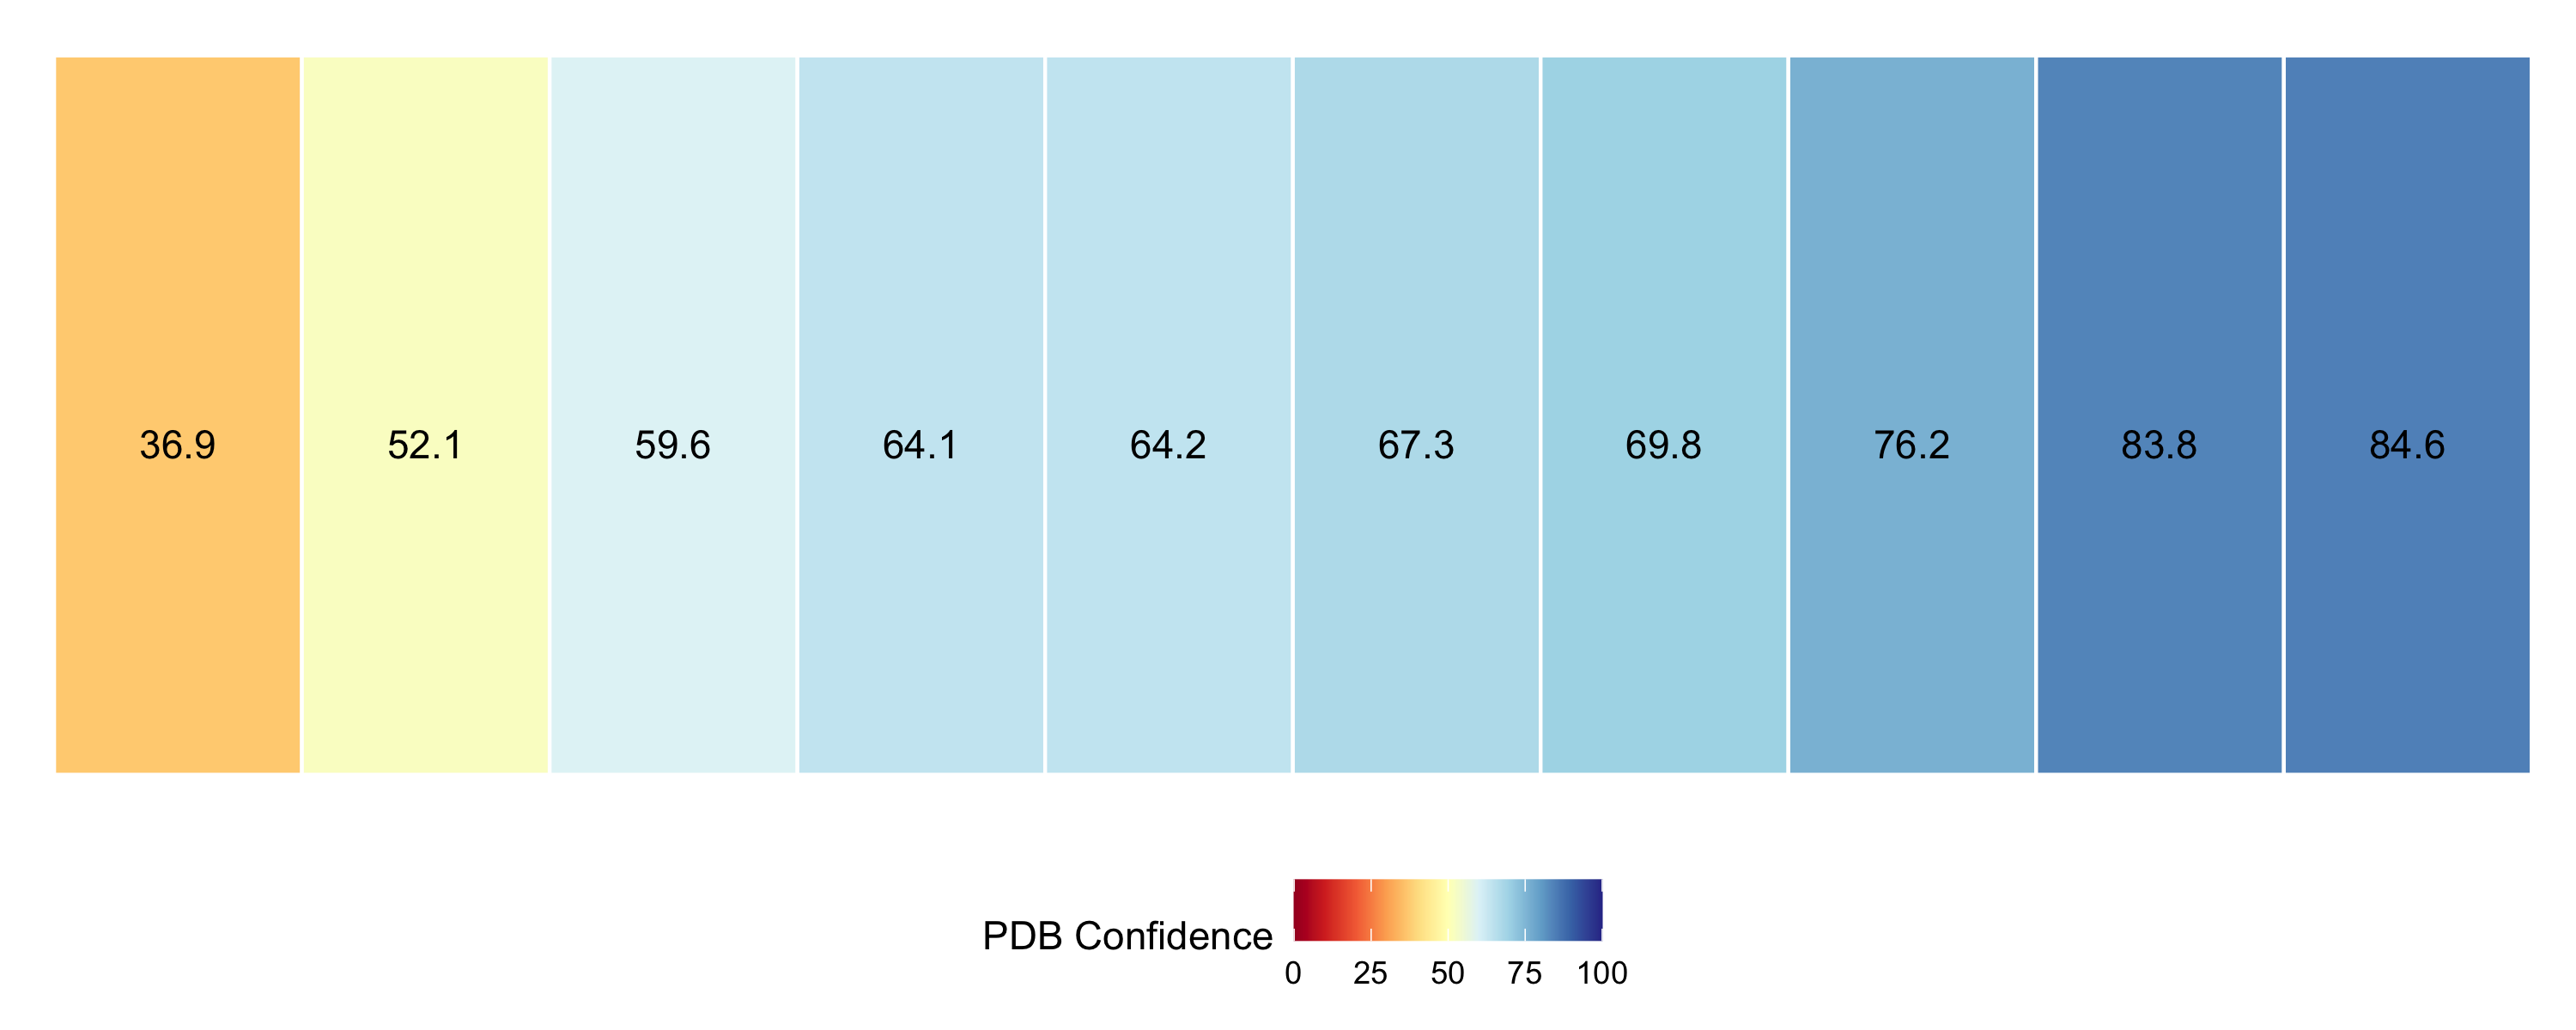

In [9]:
# PDB quality information for protease inhibitors and human proteases

# protease inhibitors
pi_pdb_info <- read_tsv("../inputs/tick_protease_proteins/tick_pi_pdb_info.txt", show_col_types = FALSE)

pi_pdb_info <- pi_pdb_info %>% 
    arrange(pdb_confidence) %>% 
    mutate(protid = forcats::fct_inorder(protid))

ordered_ids <- pi_pdb_info$protid
ordered_ids_without_prefix <- gsub("Amblyomma-americanum_evm.model.contig-", "", ordered_ids)


pi_confidence_heatmap <- pi_pdb_info %>% 
  ggplot(aes(x = protid, y = 0, fill = pdb_confidence)) +
  geom_tile(color = "white", size = 0.5) +
  scale_fill_gradientn(
    colours = RColorBrewer::brewer.pal(11, "RdYlBu"),
    values = scales::rescale(c(0, 100)),
    name = "PDB Confidence",
    limits = c(0, 100)
  ) +
  geom_text(aes(label = sprintf("%.1f", pdb_confidence)), vjust = 1.5, color = "black") +
  labs(
    x = "Protein ID", 
    y = ""
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.title.x = element_blank(),
    axis.text.y = element_blank(),  
    axis.title.y = element_blank(),
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(), 
    panel.border = element_blank(),
    legend.position="bottom"
  )


pi_confidence_heatmap

Joining with `by = join_by(amblyomma_protein, uniprot_id)`


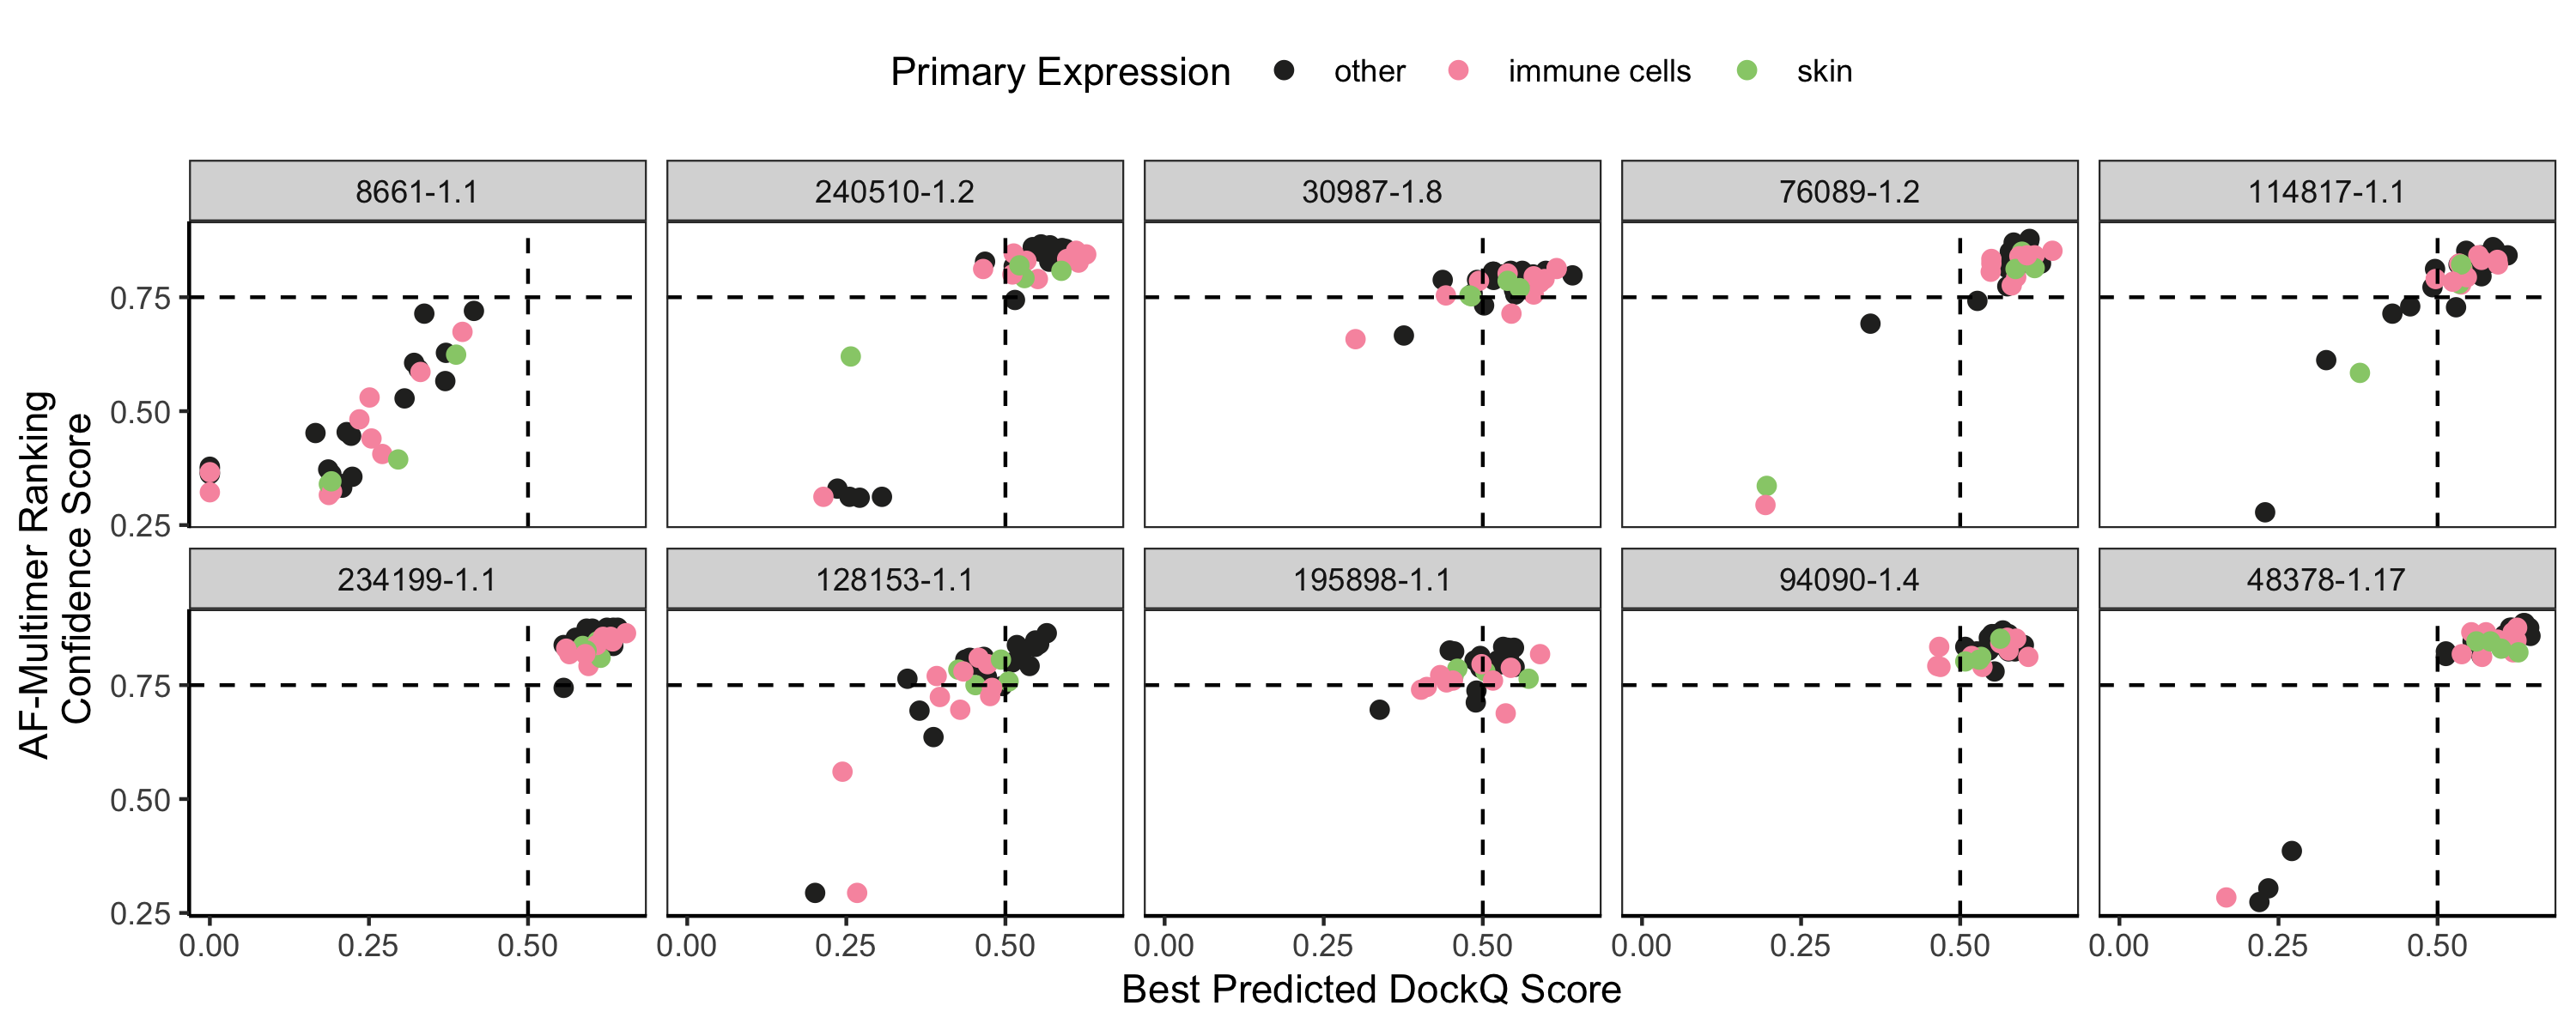

In [18]:
# read in results CSV that has pDockQ score
majority_interface_results <- read.csv("../results/serine_protease_results/select_tick_serine_protease_afmultimer_raw_results/select_tick_serine_protease_results_analysis/summary.csv") %>% 
    separate(complex_name, "_vs_", into=c("amblyomma_protein", "uniprot_id"))

Amblyomma_94090_interface_results <- read.csv("../results/serine_protease_results/Amblyomma-americanum-94090-select-serine-protease-afmultimer-results_analysis/summary.csv") %>% 
    separate(complex_name, "_vs_", into=c("amblyomma_protein", "uniprot_id"))

all_interface_results <- rbind(majority_interface_results, Amblyomma_94090_interface_results)

# combine with metadata
all_interface_results_metadata <- left_join(all_interface_results, combined_results_metadata) %>%
  mutate(
    amblyomma_id = gsub("Amblyomma-americanum_evm.model.contig-", "", amblyomma_protein),
    amblyomma_id = factor(amblyomma_id, levels = ordered_ids_without_prefix)
  )

# plot and facet by amblyomma protein id
all_interface_comps_plot <- all_interface_results_metadata %>%
    filter(primary_expression != "none") %>% 
    mutate(important = ifelse(primary_expression == "other", 0, 1)) %>% # this puts the "other" expression points towards the back with factor levels so the colored points are at the front
    arrange(important) %>%
    mutate(primary_expression = factor(primary_expression, levels = unique(primary_expression))) %>% 
    ggplot(aes(x=best_pdockq, y=afmultimer_ranking_confidence)) +
    geom_point(aes(color = primary_expression), size=2) +
    scale_color_manual(values = c("#292928", "#F898AE", "#97CD78"), name="Primary Expression") +
    scale_x_continuous(breaks = seq(0, 1, by = 0.25)) +
    scale_y_continuous(breaks = seq(0, 1, by = 0.25)) +
    facet_wrap(~amblyomma_id, nrow = 2) + 
    theme_bw() +
    xlab("Best Predicted DockQ Score") +
    ylab("AF-Multimer Ranking \nConfidence Score") +
    geom_hline(yintercept = 0.75, linetype = "dashed", color = "black") +
    geom_vline(xintercept = 0.5, linetype = "dashed", color = "black") +
    theme(legend.position = "top") +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

all_interface_comps_plot


In [19]:
# save tables and plots
# final table of results
write.table(all_interface_results_metadata, "../results/serine_protease_results/2024-04-24-final-serine-protease-filtered-interface-comps-results.tsv", sep = "\t", quote = FALSE, row.names = FALSE)

# plots
ggsave("../figs/all-serine-protease-afmultimer-interaface-comps.png", all_interface_comps_plot, width=13, height=5, units=c("in"))
ggsave("../figs/all-serine-protease-afmultimer-interface-comps.pdf", all_interface_comps_plot, width=11, height=5, units=c("in"))

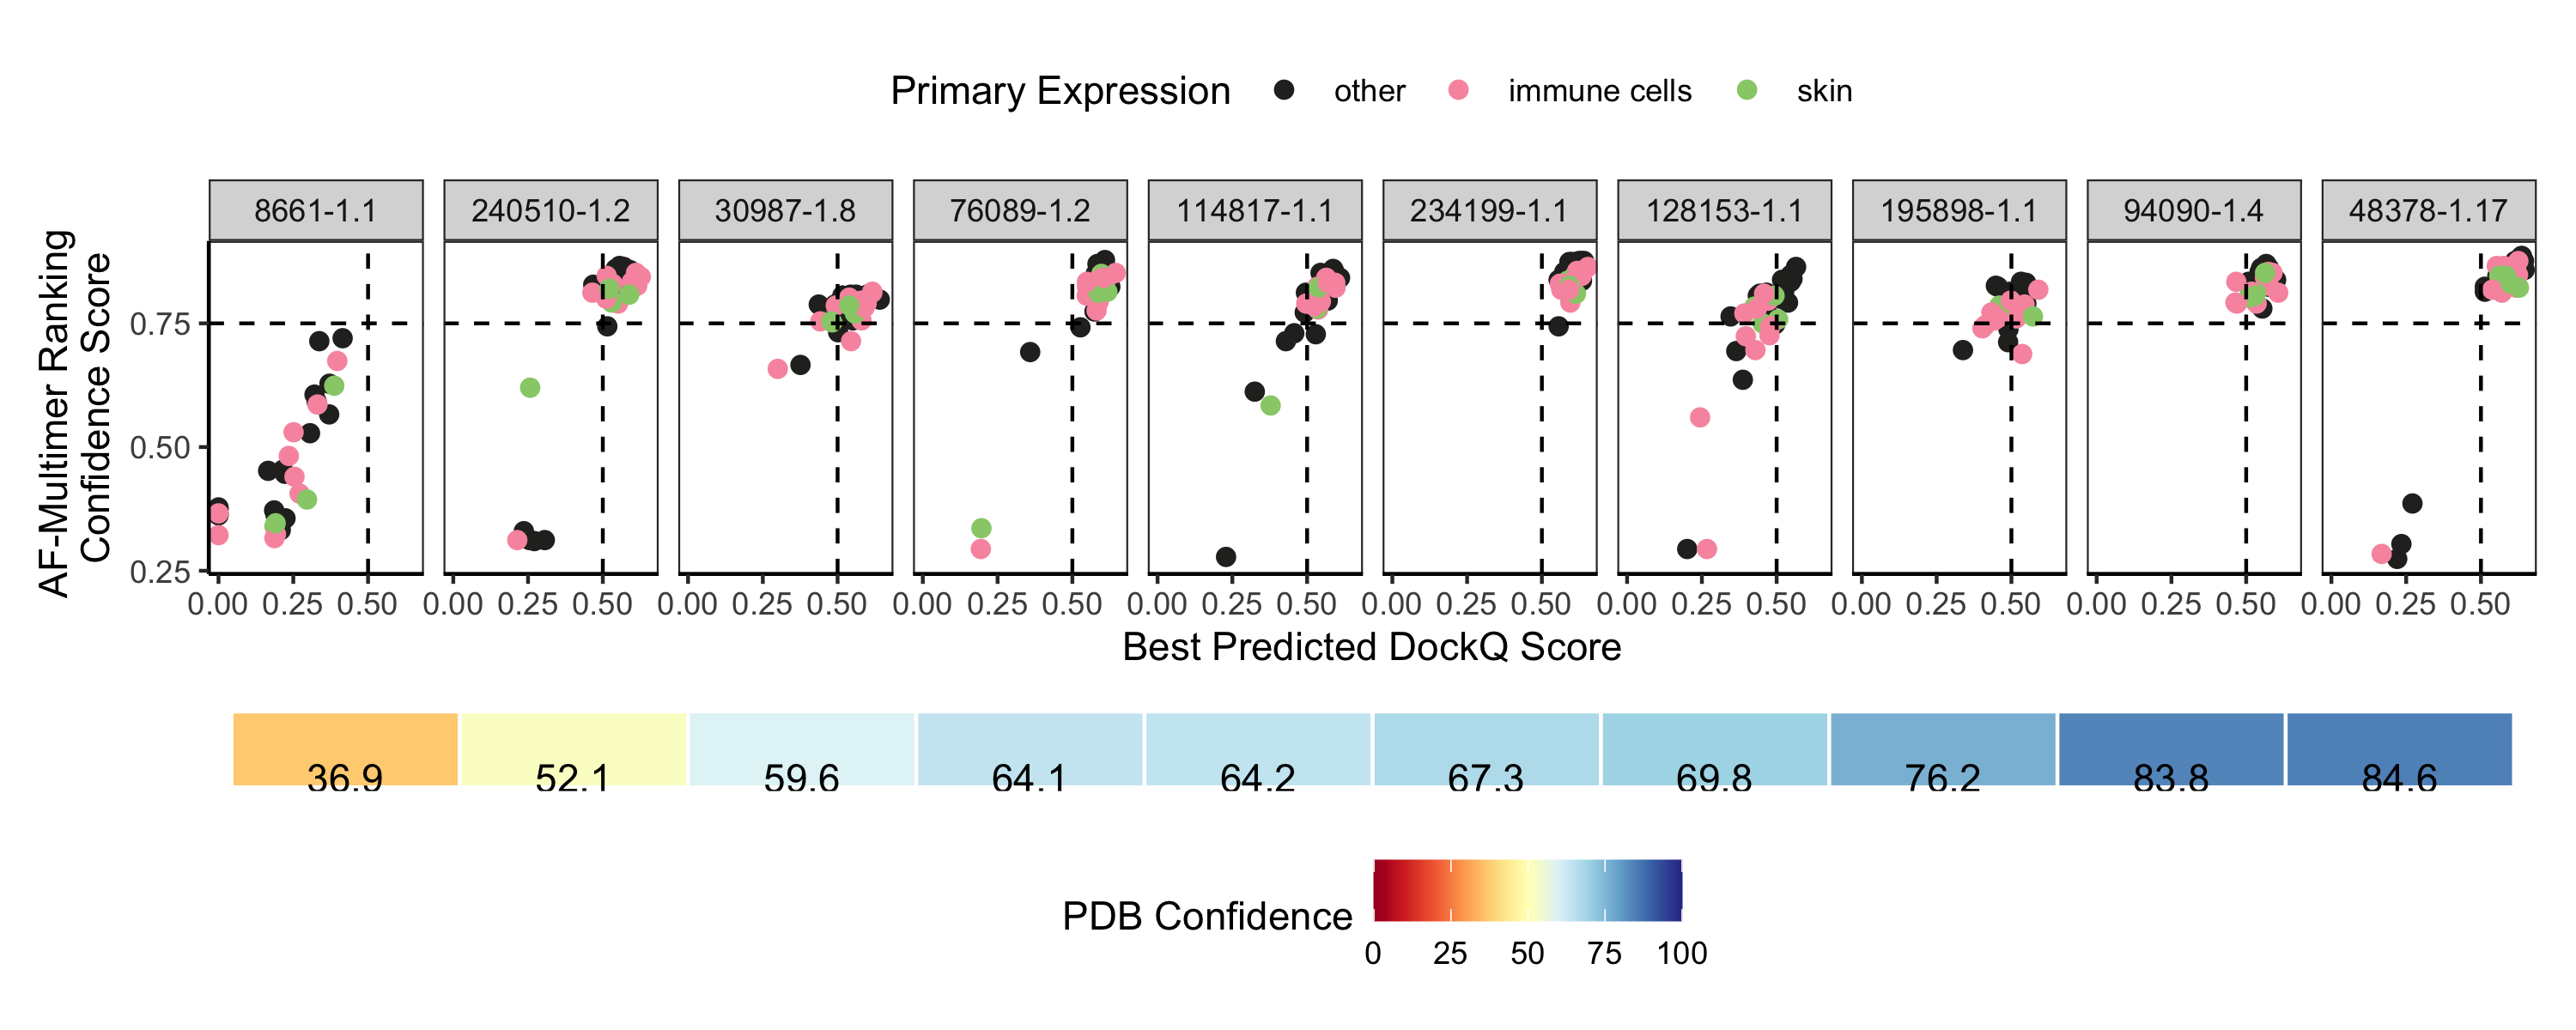

In [20]:
# combine plots together

all_interface_1row <- all_interface_comps_plot + 
    facet_wrap(~amblyomma_id, nrow=1)


combined_plot <- all_interface_1row / pi_confidence_heatmap + plot_layout(heights = c(4,1), ncol=1)

combined_plot

ggsave("../figs/combined_interface_qual_pi_afmultimer_plot.png", combined_plot, width=15, height=5, units=c("in"))
ggsave("../figs/combined_interface_qual_pi_afmultimer_plot.pdf", combined_plot, width=15, height=5, units=c("in"))

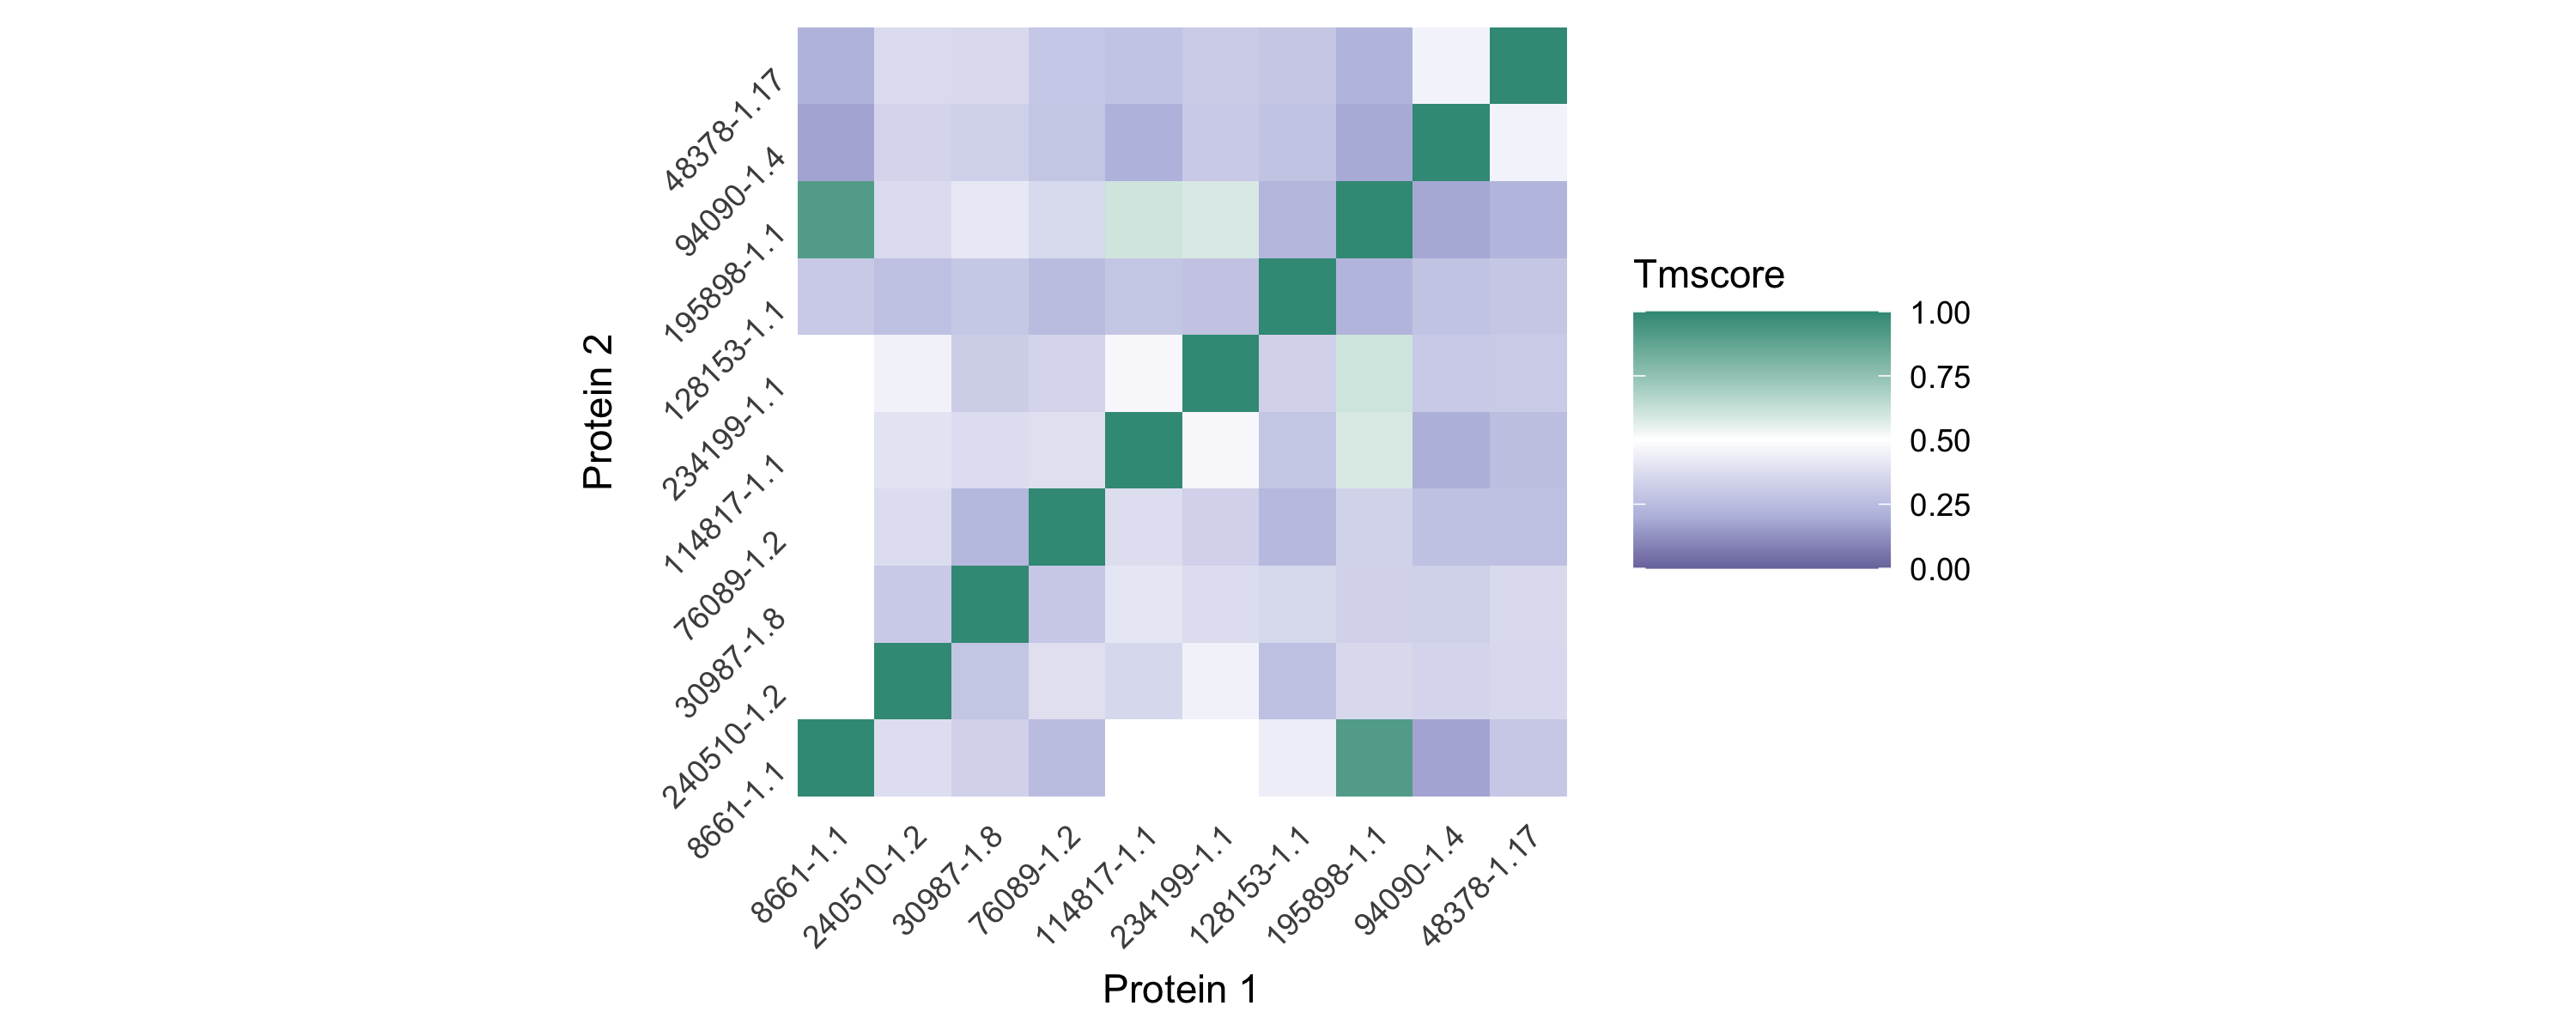

In [14]:
# all-v-all TMscore alignments for protease inhibitors and human proteases from foldseek easy-search

# protease inhibitors
pi_all_v_all_tmscores <- read_tsv("../inputs/tick_protease_proteins/tick_protease_inhibitors_all_v_all.txt", show_col_types = FALSE, col_names = c("protein_1", "protein_2", "tmscore")) %>% 
    select(protein_1, protein_2, tmscore) %>% 
    pivot_longer(cols = tmscore, names_to = "variable", values_to = "value") %>% 
    mutate(
    protein_1_modf = gsub("Amblyomma-americanum_evm.model.contig-", "", protein_1),
    protein_2_modf = gsub("Amblyomma-americanum_evm.model.contig-", "", protein_2),
    protein_1_modf = gsub(".pdb", "", protein_1_modf),
    protein_2_modf = gsub(".pdb", "", protein_2_modf),
    protein_1_modf = factor(protein_1_modf, levels = ordered_ids_without_prefix),
    protein_2_modf = factor(protein_2_modf, levels = ordered_ids_without_prefix)
  )

# pi all-v-all tmscores heatmap
pi_tmscore_heatmap <- ggplot(pi_all_v_all_tmscores, aes(x = protein_1_modf, y = protein_2_modf, fill = value)) +
  geom_tile() +
    scale_fill_gradientn(
        colors = c("#7A77AB", "#BABEE0", "#FFFFFF", "#3B9886"),
        values = scales::rescale(c(0, 0.2, 0.5, 1)),
        limits = c(0, 1),
        guide = guide_colorbar(title = "Tmscore", barwidth = 5, barheight = 5)
    ) +
  labs(x = "Protein 1", y = "Protein 2", fill = "Tmscore") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), 
        axis.text.y = element_text(angle = 45, hjust = 1, vjust = 1),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        panel.border = element_blank()) +
  coord_fixed()

pi_tmscore_heatmap

# save plot
ggsave('../figs/pi_tmscore_comps_heatmap.png', pi_tmscore_heatmap, width=11, height=8, units=c("in"))
ggsave('../figs/pi_tmscore_comps_heatmap.pdf', pi_tmscore_heatmap, width=11, height=8, units=c("in"))

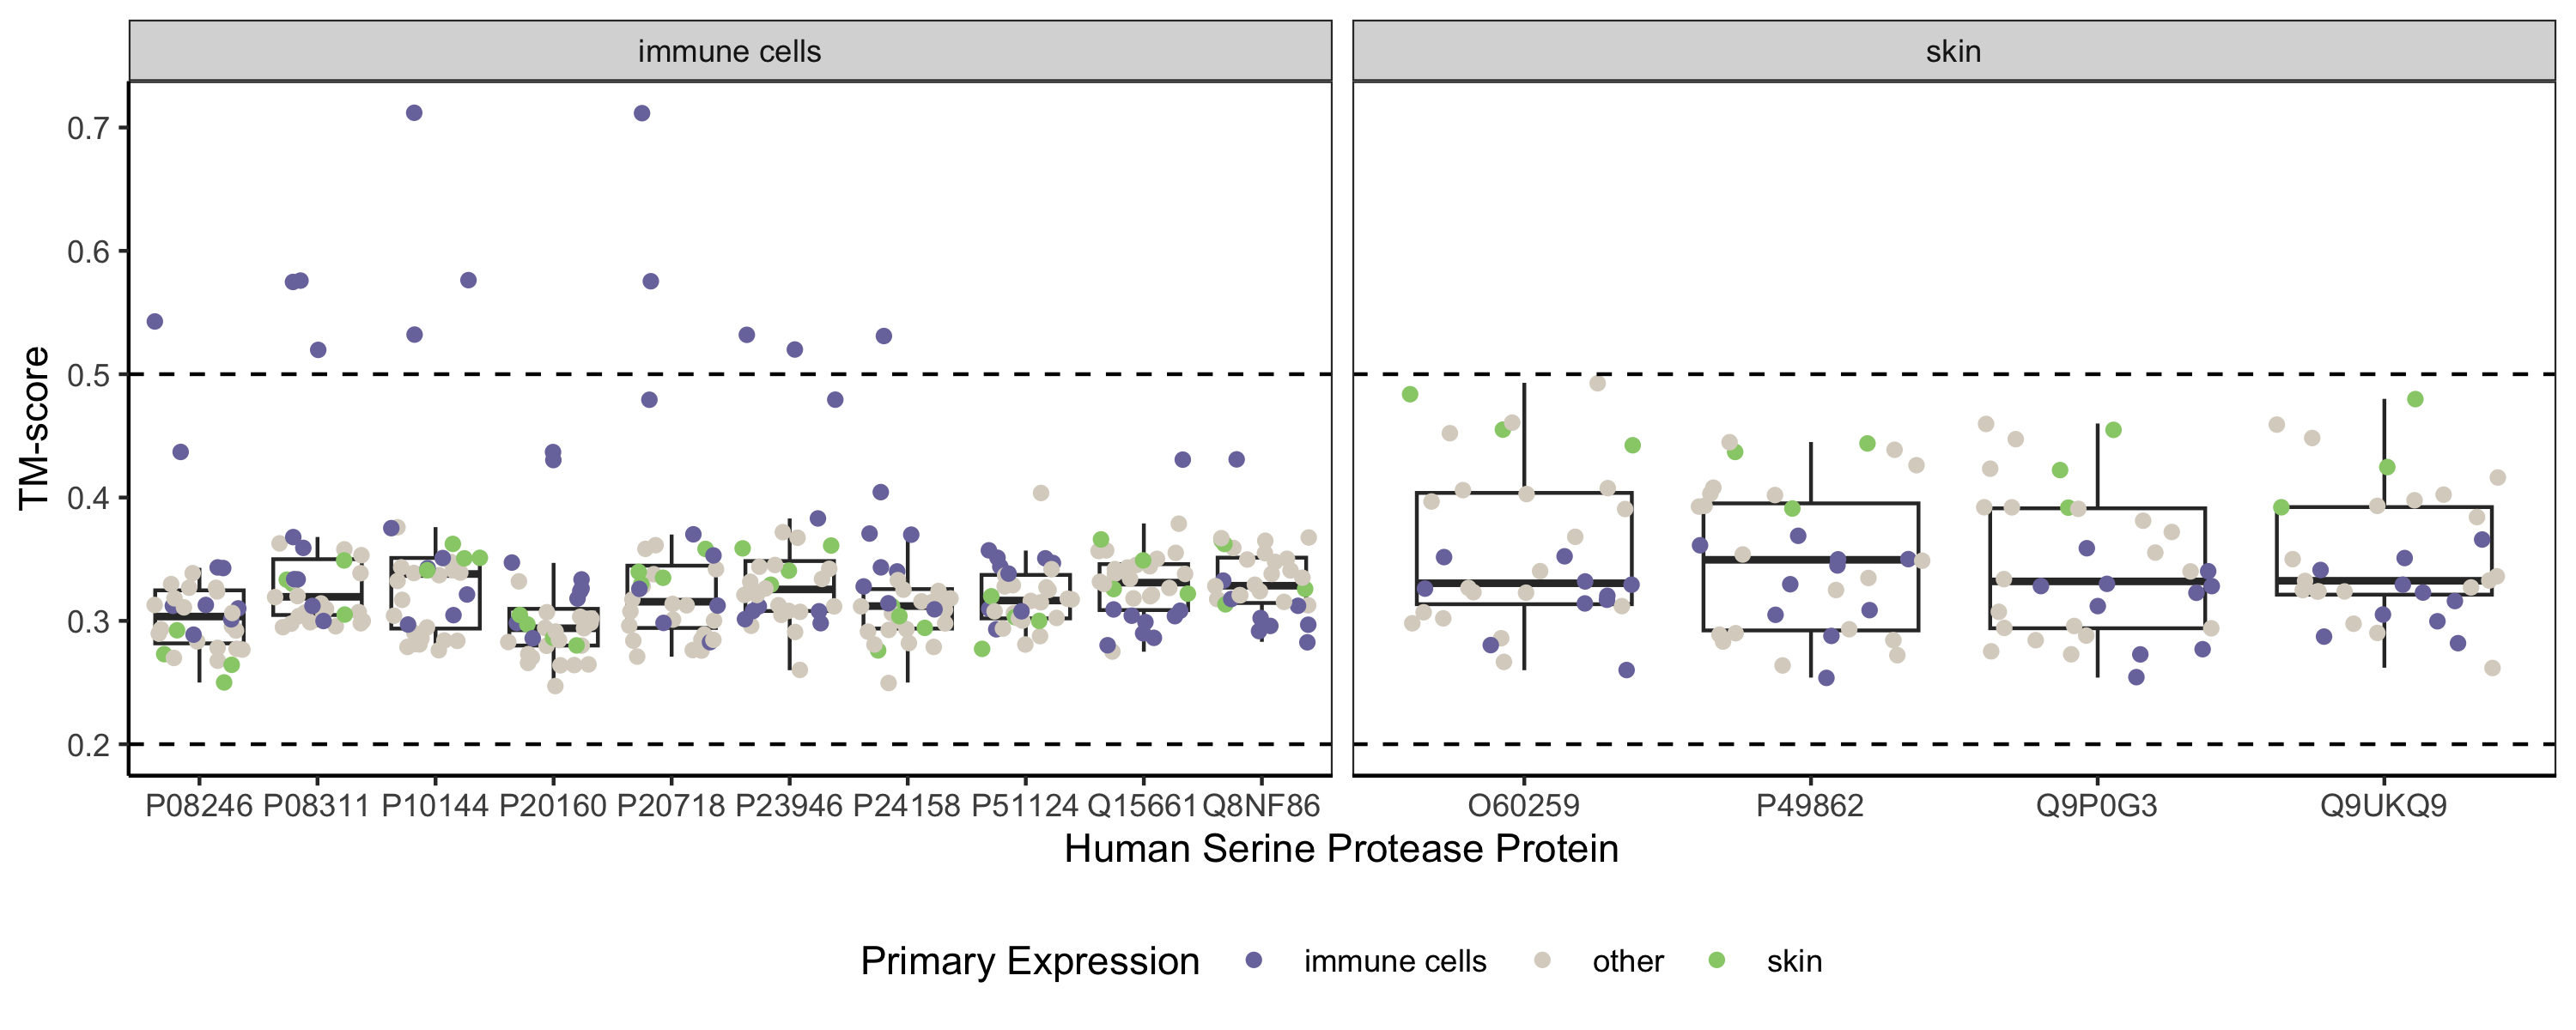

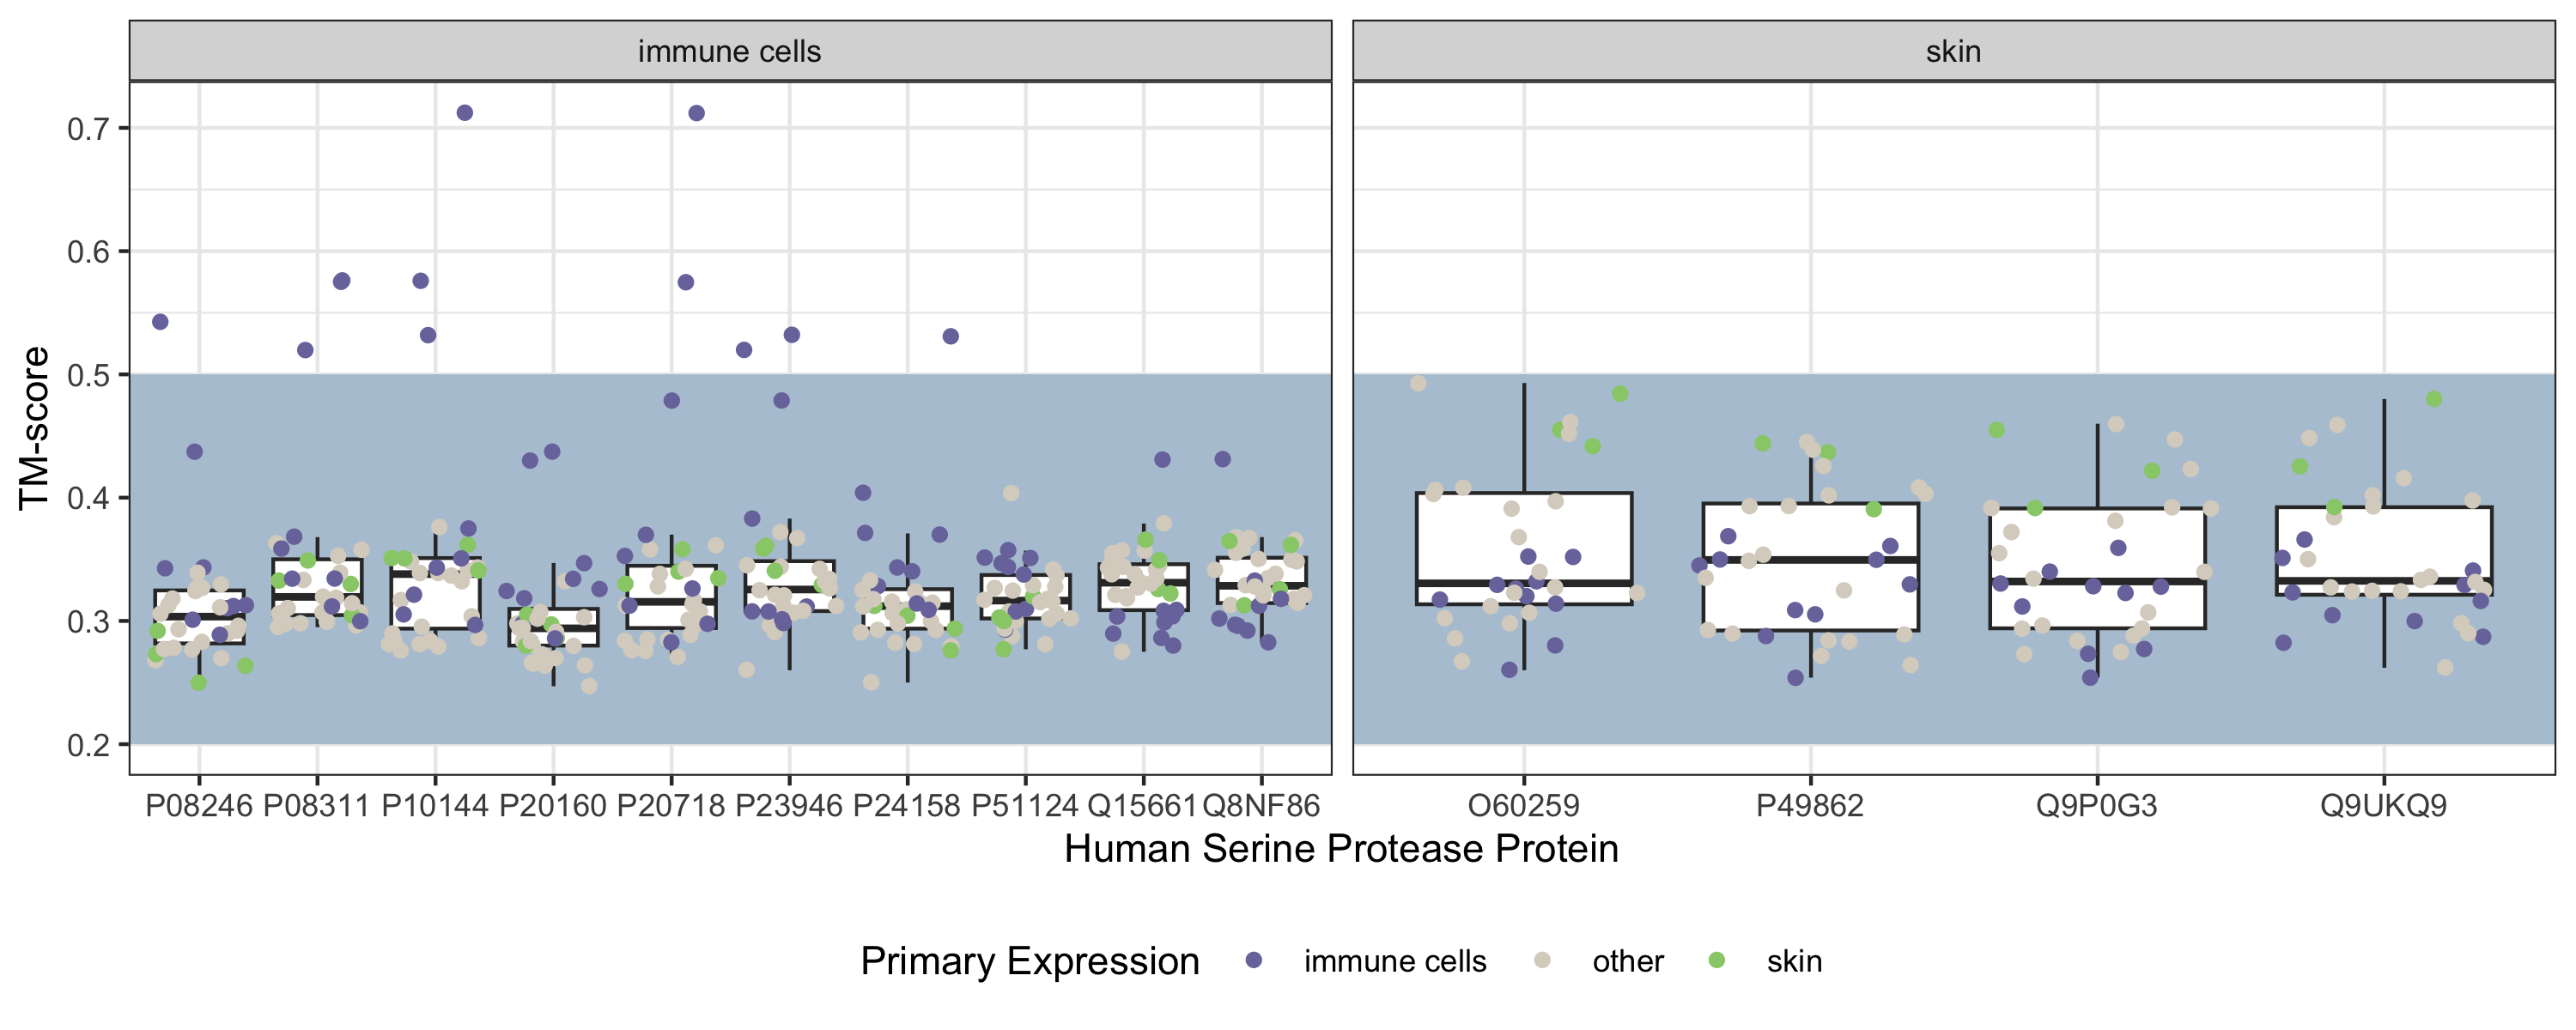

In [15]:
# human proteases
human_proteases_all_v_all_tmscores <- read_tsv("../inputs/uniprot_proteins/select_serine_protease_uniprot_accessions/serine_protease_all_v_all_tmscores.tsv", show_col_types = FALSE, col_names = c("protein_1", "protein_2", "tmscore")) %>% 
    select(protein_1, protein_2, tmscore) %>% 
    pivot_longer(cols = tmscore, names_to = "variable", values_to = "value") %>% 
    mutate(protein_1 = gsub(".pdb", "", protein_1)) %>% 
    mutate(protein_2 = gsub(".pdb", "", protein_2)) %>% 
    left_join(serine_protease_metadata, by=c("protein_1" = "uniprot_id")) %>% 
    rename(primary_expression_1 = primary_expression) %>% 
    left_join(serine_protease_metadata, by=c("protein_2" = "uniprot_id")) %>% 
    rename(primary_expression_2 = primary_expression)

human_protease_tmscore_comps_boxplot <- human_proteases_all_v_all_tmscores %>% 
    filter(primary_expression_1 == "skin" | primary_expression_1 == 'immune cells') %>% 
    filter(value < 1) %>% 
    filter(primary_expression_2 != "none") %>% 
    ggplot(aes(x=protein_1, y=value)) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(aes(color=primary_expression_2)) +
    scale_color_manual(values = c("#7A77AB", "#DAD3C7", "#97CD78"), name="Primary Expression") +
    facet_wrap(~ primary_expression_1, scales = "free_x") +
    xlab("Human Serine Protease Protein") +
    ylab("TM-score") +
    geom_hline(yintercept = 0.2, linetype = "dashed", color = "black") +
    geom_hline(yintercept = 0.5, linetype = "dashed", color = "black") +
    theme_bw() +
    theme(legend.position="bottom") +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

human_protease_tmscore_comps_boxplot_shaded <- human_proteases_all_v_all_tmscores %>% 
    filter(primary_expression_1 == "skin" | primary_expression_1 == 'immune cells') %>% 
    filter(value < 1) %>% 
    filter(primary_expression_2 != "none") %>% 
    ggplot(aes(x=protein_1, y=value)) +
    geom_rect(aes(xmin = -Inf, xmax = Inf, ymin = 0.2, ymax = 0.5), fill = "#B6C8D4", alpha = .1) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(aes(color=primary_expression_2)) +
    scale_color_manual(values = c("#7A77AB", "#DAD3C7", "#97CD78"), name="Primary Expression") +
    facet_wrap(~ primary_expression_1, scales = "free_x") +
    xlab("Human Serine Protease Protein") +
    ylab("TM-score") +
    theme_bw() +
    theme(legend.position="bottom")

human_protease_tmscore_comps_boxplot
human_protease_tmscore_comps_boxplot_shaded

ggsave("../figs/human_protease_tmscore_comps.png", human_protease_tmscore_comps_boxplot, width=8, height=5, units=c("in"))
ggsave("../figs/human_protease_tmscore_comps_shaded.png", human_protease_tmscore_comps_boxplot_shaded, width=8, height=5, units=c("in"))

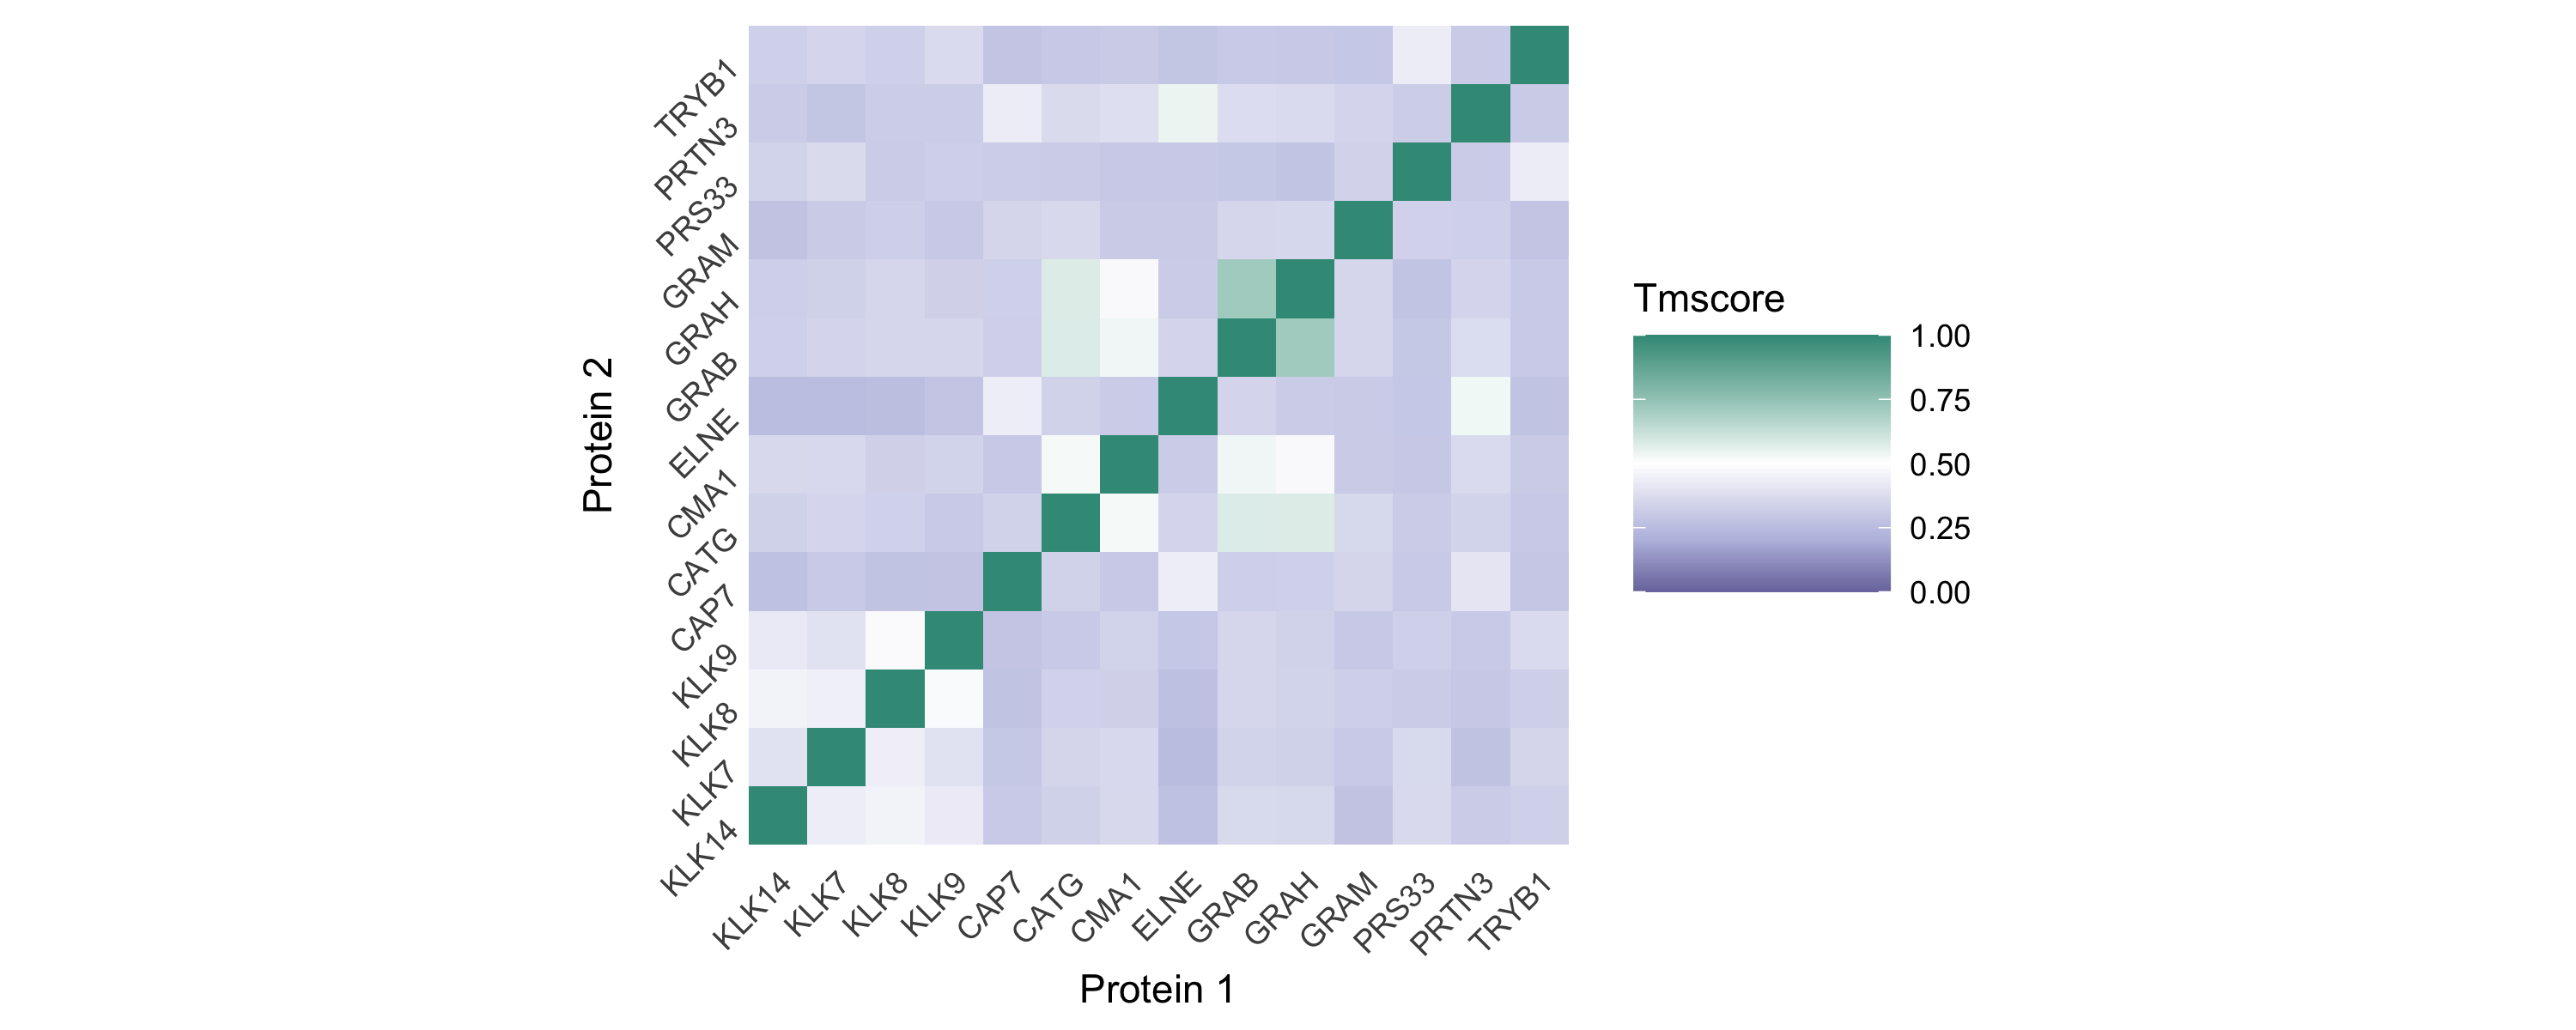

In [16]:
# all-v-all tmscore comparisons heatmap for all proteases, heatmap of just those of interest

# Generate the unique and ordered protein lists
protein_order <- human_proteases_all_v_all_tmscores %>%
  mutate(protein_1_uniprot_name = gsub("_HUMAN", "", uniprot_name.x),
         protein_2_uniprot_name = gsub("_HUMAN", "", uniprot_name.y)) %>%
  filter(primary_expression_1 %in% c("immune cells", "skin"),
         primary_expression_2 %in% c("immune cells", "skin")) %>%
  select(protein_1_uniprot_name, protein_2_uniprot_name) %>%
  distinct() %>%
  arrange(desc(grepl("^KLK", protein_1_uniprot_name)), protein_1_uniprot_name,
          desc(grepl("^KLK", protein_2_uniprot_name)), protein_2_uniprot_name) %>%
  distinct()

# Apply the unique and ordered levels to the main data frame
plot_data <- human_proteases_all_v_all_tmscores %>%
  mutate(protein_1_uniprot_name = gsub("_HUMAN", "", uniprot_name.x),
         protein_2_uniprot_name = gsub("_HUMAN", "", uniprot_name.y)) %>%
  filter(primary_expression_1 %in% c("immune cells", "skin"),
         primary_expression_2 %in% c("immune cells", "skin")) %>%
  mutate(protein_1_uniprot_name = factor(protein_1_uniprot_name, levels = unique(protein_order$protein_1_uniprot_name)),
         protein_2_uniprot_name = factor(protein_2_uniprot_name, levels = unique(protein_order$protein_2_uniprot_name)))

# plot
human_protease_selected_tmscore_comps_heatmap <- ggplot(plot_data, aes(x = protein_1_uniprot_name, y = protein_2_uniprot_name, fill = value)) +
  geom_tile() +
  scale_fill_gradientn(colors = c("#7A77AB", "#BABEE0", "#FFFFFF", "#3B9886"),
                       values = scales::rescale(c(0, 0.2, 0.5, 1)),
                       limits = c(0, 1),
                       guide = guide_colorbar(title = "Tmscore", barwidth = 5, barheight = 5)) +
  labs(x = "Protein 1", y = "Protein 2", fill = "Tmscore") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), 
        axis.text.y = element_text(angle = 45, hjust = 1, vjust = 1),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        panel.border = element_blank()) +
  coord_fixed()

human_protease_selected_tmscore_comps_heatmap
ggsave("../figs/selected_human_protease_tmscore_comps_heatmap.png", human_protease_selected_tmscore_comps_heatmap, width=11, height=8, units=c("in"))
ggsave("../figs/selected_human_protease_tmscore_comps_heatmap.pdf", human_protease_selected_tmscore_comps_heatmap, width=11, height=8, units=c("in"))

# Conclusions
From these analyses, we found that most of the 35 serine proteases have high confident PPIs with the 10 tick protease inhibitors, with the exception of the low quality protease inhibitor structure. We hypothesized that this might be due to the human serine proteases and/or the tick protease inhibitors being highly structurally similar and therefore AF-Multimer might not be able to discriminate from these similar structures. From global TM-score alignments between these sets of proteins, they aren't really that highly similar for this to be the obvious explanation. There could be similar domains for each human serine protease that these protease inhibitors recongize, or the tick proteins have evolved different binding residues on the same protein(s) for interacting with different human proteases. Alternatively we could still be dealing with relatively high numbers of false positives and these results would need to be experimentally validated to understand how accurate AF-multimer predictions are for this type of application.

In [17]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/emcdaniel/miniconda3/envs/dev/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Los_Angeles
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.2.0 lubridate_1.9.3 forcats_1.0.0   stringr_1.5.1  
 [5] dplyr_1.1.4     purrr_1.0.2     readr_2.1.5     tidyr_1.3.1    
 [9] tibble_3.2.1    ggplot2_3.5.0   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] utf8_1.2.4         generics_0.1.3     stringi_1.8.3      hms_1.1.3         
 [5] digest_0.6.35      magrittr_2.0.3     evaluate_0.23      grid_4.3.3        
 [9] timechange_0.3.0   RColorBrewer_1.1-3 pbdZMQ_0.3-11      fastmap_1.1.1     
[13] jsonlite_1.8.8   